# UBC Lost & Found Predictive Analysis

<img src="./img/access.jpg" alt="drawing" style="width:90%;"/>
Access Services. Retrieved from <a href = "https://parking.ubc.ca/">UBC Parking</a> 

## Introduction 
---

Losing personal belongings is a common and often frustrating experience for students and staff at UBC. Items ranging from everyday essentials like wallets and keys to electronics and jewelry frequently end up in the lost and found. While the university maintains a central lost and found system, the lack of systematic analysis in these services can lead to inefficiencies, making it harder to identify trends and optimize recovery processes. By analyzing the UBC lost and found dataset, this project aims to uncover patterns in lost items, predict future trends, and provide actionable insights to enhance the efficiency of UBC's lost and found services.

**Objectives**: 
- **Item Classification Analysis**: Identify the most frequently lost item categories (e.g., electronics, wallets, keys).
- **Temporal Analysis**: Examine seasonal and daily trends in lost item reports.
- **Location Analysis**: Identify the most common campus locations where items are lost and found.
- **Item Description Analysis**: Group similar items based on "Item Description" to identify detailed subcategories of lost items using NLP techniques
- **Time Series Forecasting**: Develop predictive models to forecast the number of items reported to the lost and found using historical data.
- **Recommendations**: Provide actionable recommendations to improve the lost and found system, including targeted awareness campaigns, optimized item storage, and enhanced communication channels.


## Dataset
---

The [UBC Lost and Found database](https://lostandfound.ubc.ca/all-items) is a publicly accessible dataset containing information about items reported lost within the University of British Columbia campus. The dataset spans from May 2024 to the current day, with over 150 entries. Each entry includes details such as the item type, description, date lost, and location. We will be using the dataset retrieved as of January 2025 for the project.

### Loading libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import mglearn
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from statsmodels.tsa.arima.model import ARIMA

### Importing the data

In [2]:
url = "https://lostandfound.ubc.ca/all-items/export.csv"
df = pd.read_csv(url, index_col = "Date")

df.head()

Ticket Number    Item Type Status          Item Description  \
Date                                                                            
January 20, 2025          47186  Electronics   Lost     Headphones (Over ear)   
January 20, 2025          47185         Keys   Lost  2 keys on key ring, etc.   
January 20, 2025          47184         Keys   Lost     Single key on lanyard   
January 17, 2025          47182      Jewelry   Lost               Metal Watch   
January 16, 2025          47181      Jewelry   Lost             Two tone Ring   

                 Lost Item Location  
Date                                 
January 20, 2025              Other  
January 20, 2025              Other  
January 20, 2025              Other  
January 17, 2025            Library  
January 16, 2025              Other

## Data Wrangling & Cleaning
---

### Examining the data

We begin by exploring the dataset to understand its structure.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161 entries, January 20, 2025 to May 31, 2024
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Ticket Number       161 non-null    int64 
 1   Item Type           161 non-null    object
 2   Status              159 non-null    object
 3   Item Description    161 non-null    object
 4   Lost Item Location  119 non-null    object
dtypes: int64(1), object(4)
memory usage: 7.5+ KB


In [4]:
df.describe(include = "all")

Ticket Number    Item Type Status Item Description Lost Item Location
count      161.000000          161    159              161                119
unique            NaN            7      1              143                  4
top               NaN  Electronics   Lost       Headphones              Other
freq              NaN           63    159                3                 95
mean     47069.223602          NaN    NaN              NaN                NaN
std         71.891061          NaN    NaN              NaN                NaN
min      46923.000000          NaN    NaN              NaN                NaN
25%      47010.000000          NaN    NaN              NaN                NaN
50%      47069.000000          NaN    NaN              NaN                NaN
75%      47129.000000          NaN    NaN              NaN                NaN
max      47186.000000          NaN    NaN              NaN                NaN

### Handling missing values

In [5]:
df.isna().sum()

Ticket Number          0
Item Type              0
Status                 2
Item Description       0
Lost Item Location    42
dtype: int64

- For the `Lost Item Location` column, missing values will be replaced with "`Unknown`" to ensure data completeness.
- Missing values in the `Status` column are minimal (2 rows) and will not be addressed as they have no impact on analysis.

In [6]:
value = {"Lost Item Location": "Unknown"}
df.fillna(value=value, inplace=True)

### Datetime Conversion

To facilitate temporal analysis, the `Date` index is converted to a proper datetime object. Additional features like `Year`, `Month`, and `Weekday` are also extracted.

In [7]:
df.index = pd.to_datetime(df.index)
df['Year'] = df.index.year
df['Month'] = df.index.month_name()
df['Weekday'] = df.index.day_name()

### Cleaning the data

To finalize the data preparation, we will check for any duplicated values and ensure chronological consistency by sorting the dataset by date.

In [8]:
print(f"Number of duplicates: {df.duplicated().sum()}")

Number of duplicates: 0


In [9]:
df = df.sort_values('Date', ascending=True)

After cleaning, the dataset is sorted by date. Below is a preview of the first five rows:

In [10]:
df.head()

Ticket Number    Item Type Status    Item Description  \
Date                                                                
2024-05-31          46923      Jewelry   Lost        Woman's ring   
2024-06-05          46927  Electronics   Lost         Digital Pen   
2024-06-05          46925         Keys   Lost  Single key on ring   
2024-06-05          46926      Jewelry   Lost     Silver ear ring   
2024-06-05          46928      Jewelry   Lost   Ear ring (beaded)   

           Lost Item Location  Year Month    Weekday  
Date                                                  
2024-05-31            Library  2024   May     Friday  
2024-06-05              Other  2024  June  Wednesday  
2024-06-05            Library  2024  June  Wednesday  
2024-06-05            Library  2024  June  Wednesday  
2024-06-05            Library  2024  June  Wednesday

## Exploratory Data Analysis
--- 

### Item Classification Analysis

**Objective**: Identify the most frequently lost item categories.

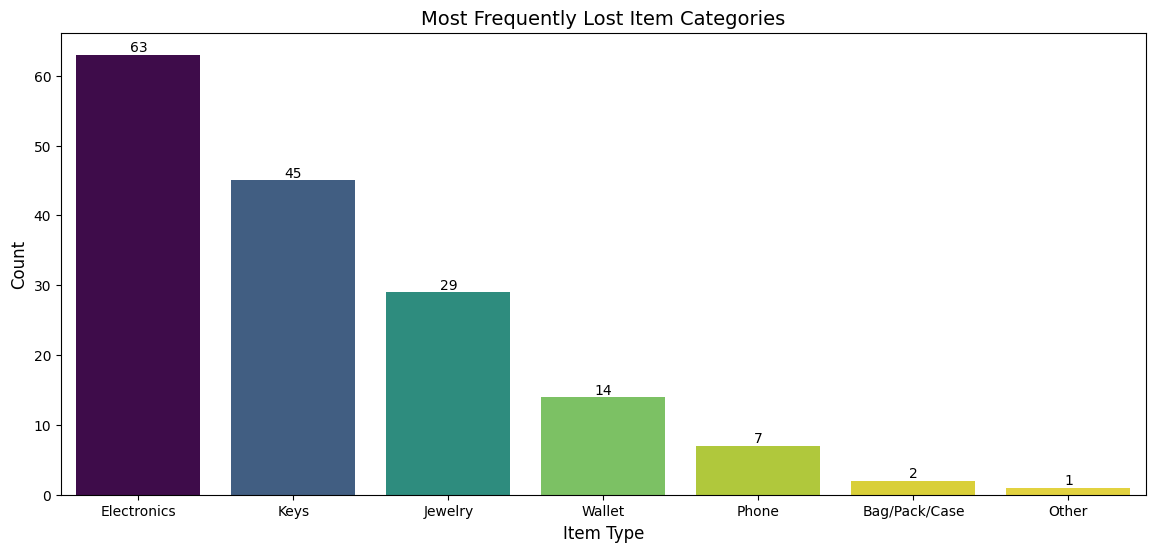

In [11]:
item_type_counts = df['Item Type'].value_counts()

fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
ax = sns.barplot(x=item_type_counts.index, y=item_type_counts.values, palette='viridis_r', hue = item_type_counts.values, legend = False)
ax.set_xlabel("Item Type", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)
ax.set_title("Most Frequently Lost Item Categories", fontsize = 14)

for i in ax.containers:
    ax.bar_label(i)
    
plt.show()

The bar plot above illustrates the distribution of lost items by type, highlighting the most frequently reported categories in the dataset. Electronics are the most commonly lost items, accounting for 62 reports, followed by keys with 44 reports and jewelry with 29 reports. Other categories, such as wallets and phones, are less frequent, while items classified as "Other" and bag/pack/case are rarely reported.

The analysis shows that certain item types, particularly electronics and keys, dominate the dataset. These findings suggest that targeted awareness campaigns or recovery strategies should focus on these high-frequency categories to maximize the effectiveness of lost and found services.

### Temporal Analysis

**Objective**: Examine seasonal and daily trends in lost item reports.

#### Monthly Trends

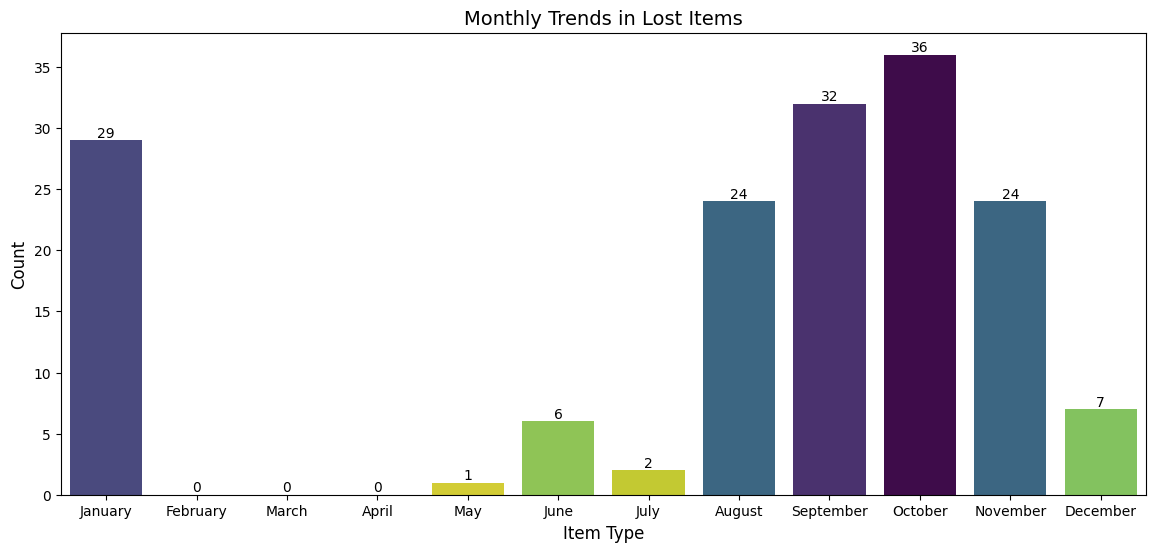

In [12]:
monthly_counts = df['Month'].value_counts().reindex(
    ["January", "February", "March", "April", "May", "June", 
     "July", "August", "September", "October", "November", "December"])
monthly_counts.fillna(0, inplace = True)

fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
ax = sns.barplot(x=monthly_counts.index, y=monthly_counts.values, palette='viridis_r', hue = monthly_counts.values, legend = False)
ax.set_xlabel("Item Type", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)
ax.set_title("Monthly Trends in Lost Items", fontsize = 14)

for i in ax.containers:
    ax.bar_label(i)
    
plt.show()

The bar plot above highlights the number of lost items each month. Key observations include:
- October has the highest number of reports with 36 lost items, followed closely by September (32) and January (27)
- There is a noticeable absence of data for February, March, and April, so no conclusions can be drawn about lost item trends during these months
- The months of May, June, and July show low to moderate activity, ranging from 1 to 6 lost items.

These monthly trends suggest that the frequency of lost items follow closely with the university's academic calendar. Peaks in lost items during September, October, and January may correspond to the start of the academic term, where student activity on campus is at its peak. Conversely, the low counts during the summer months suggest that there are fewer people on campus.

#### Weekday Trends Across Months

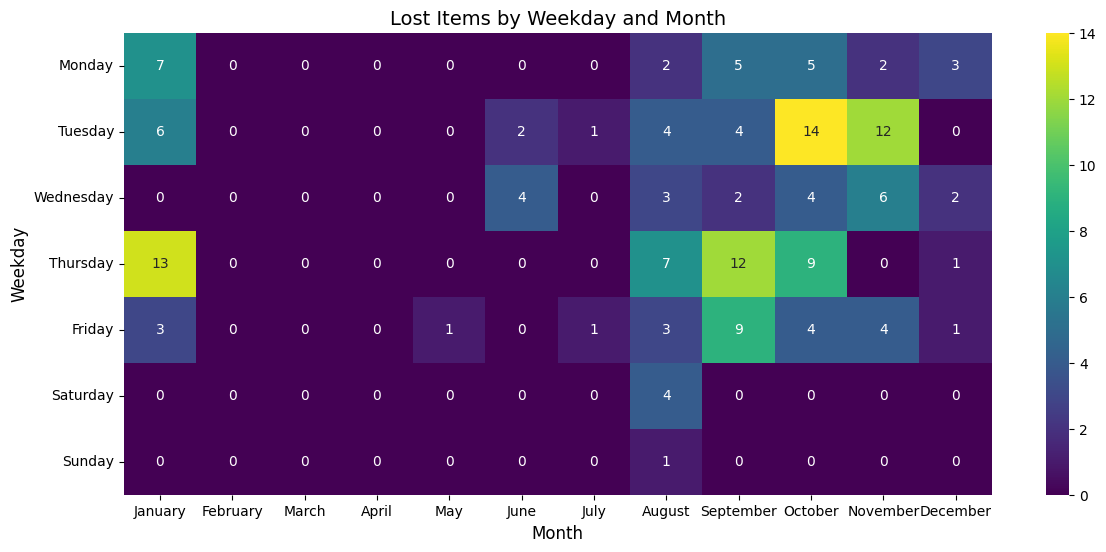

In [13]:
weekday_counts = pd.crosstab(df['Weekday'], df['Month'], margins = True)
weekday_counts = weekday_counts.reindex(index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", 
     "Sunday"], columns = ["January", "February", "March", "April", "May", "June", 
     "July", "August", "September", "October", "November", "December"])
weekday_counts.fillna(0, inplace = True)
weekday_counts = weekday_counts.astype("int")

fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
ax = sns.heatmap(weekday_counts, cmap="viridis", annot=True, fmt='d')
ax.set_xlabel("Month", fontsize = 12)
ax.set_ylabel("Weekday", fontsize = 12)
ax.set_title("Lost Items by Weekday and Month", fontsize = 14)

plt.show()

The heatmap above provides a detailed breakdown of lost item reports by weekday and month. Key insights include:

- Tuesday consistently shows higher reports, especially during October and November, where it peaks at 14 and 12 lost items, respectively
- Monday, Thursday and Friday show moderate activity, particularly during August to October
- Weekend days (Saturday and Sunday) have significantly lower lost item reports, which reflects lower campus activity on these days

This shows that weekday trends also follow closely with the university's schedule, with the most reports during active weekdays and fewer during weekends or months when the campus is less busy.

### Location Analysis

**Objective**: Identify the most common campus locations where items are lost.

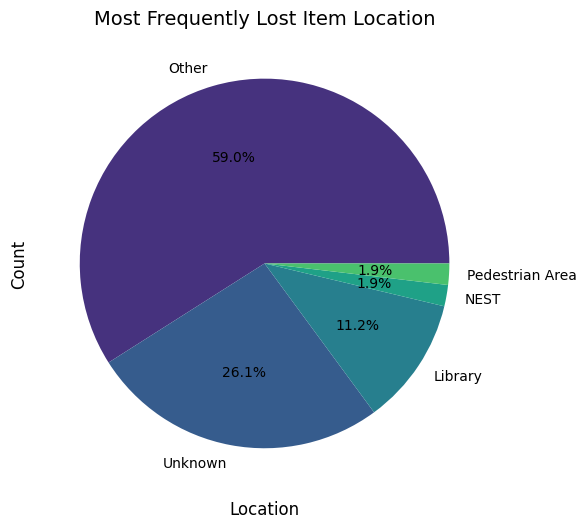

In [14]:
location_counts = df['Lost Item Location'].value_counts()
location_counts

fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
color = sns.color_palette('viridis') 
ax.pie(x = location_counts.values, labels =location_counts.index, autopct = '%1.1f%%', colors = color)
ax.set_xlabel("Location", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)
ax.set_title("Most Frequently Lost Item Location", fontsize = 14)

plt.show()

The pie chart illustrates the distribution of lost items across various campus locations:

- "Other" accounts for 65.9% of all reports. This category likely represents locations not explicitly listed or frequently visited but less defined spaces.
- "Unknown" makes up the second-largest segment, with 29.8%. These entries highlight cases where the precise location of the lost item was not specified, emphasizing the need for more detailed reporting.
- Among the specified locations:
   - The Library recorded 12.8% of all reports, making it the most common explicitly named location for lost items likely to high traffic and prolonged usage by students.
   - The NEST and Pedestrian Area both make up 2.1% of reports, indicating relatively low activity compared to other categories.

### Item Description Analysis

**Objective**: To group similar items based on "Item Description" and identify detailed subcategories of lost items, we applied natural language processing (NLP) techniques. This analysis aims to extract meaningful features and uncover underlying themes to better understand the types of items frequently lost.


#### Preprocessing

In [15]:
nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])

def preprocess(
    doc
):
    clean_text = []

    for token in doc:
        if (
            token.is_stop == False 
            and token.is_punct == False
            and token.is_alpha == True
        ):
            lemma = token.lemma_
            clean_text.append(lemma.lower())
    return " ".join(clean_text)

df["Cleaned Item Description"] = [preprocess(text) for text in nlp.pipe(df["Item Description"])]

We used the `spaCy` library to preprocess the item descriptions. The preprocessing steps included:

1. Removing stop words: Eliminates common but uninformative words like "the" or "and."
2. Removing punctuation and non-alphabetic characters: Focused on meaningful textual data.
3. Lemmatization: Reduced words to their base forms (e.g., "keys" to "key") for better grouping.

The cleaned descriptions were stored in a new column, `Cleaned Item Description`

#### Topic Modeling

In [16]:
vectorizer = CountVectorizer(stop_words=stopwords.words('english'), max_features=500, ngram_range=(1, 3))
document = vectorizer.fit_transform(df['Cleaned Item Description'])

n_topics = 7
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_decay = 0.8)
lda.fit(document)

document_topics = lda.transform(document)

We used Latent Dirichlet Allocation (LDA) for topic modeling. Key steps:

- Vectorization: CountVectorizer converted text into numerical format using unigrams, bigrams, and trigrams to capture context. A maximum of 500 features were extracted.
- LDA Model: The model identified 7 latent topics, with parameters tuned to optimize learning and topic diversity.

Here are the top 7 words associated with each topic:

In [17]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vectorizer.get_feature_names_out())

mglearn.tools.print_topics(
    topics=range(n_topics),
    feature_names=feature_names,
    sorting=sorting,
    topics_per_chunk=4,
    n_words=7,
)

topic 0       topic 1       topic 2       topic 3       
--------      --------      --------      --------      
key           case          ear           card          
ring          air           case          wallet        
single        bracelet      ear bud       airpod        
single key    pods          bud           holder        
key ring      air pods      ear bud case  card holder   
fob           airpod        bud case      unique        
lanyard       air pods case headphone     car fob       


topic 4       topic 5       topic 6       
--------      --------      --------      
watch         phone         ring          
smart         pendant       necklace      
smart watch   wallet        stone         
digital       fob combo     ago           
pen           key fob combo find          
pencil        combo         today         
headphone     chain         ago turn today




The new topics could be interpreted as followed:

|Topic	|Top Words	|Interpretation|
| ---   | ----------|--------------|
|0	|key, ring, single key, fob, lanyard	|Keys and Accessories|
|1	|case, airpod, bracelet, air pods, phone	|Cases, AirPods and Phones|
|2	|ear, bud, ear bud case, headphone	|Headphones and Ear buds|
|3	|card, wallet, card holder, silver	|Wallets and Cards|
|4	|watch, smart, smart watch	|Watches|
|5	|car, fob, car key, car fob	|Car Keys|
|6	|digital, pen, pencil	|Digital tools & Stationary|

- **Topic 0 (Keys and Accessories)**: Keys and related accessories, such as rings and lanyards, are frequently lost. Personalized keychains or name tags could improve recovery
- **Topic 1 (Cases, AirPods and Phones)**: Phones and small tech accessories are commonly lost. This highlights the importance of tracking devices or softwares
- **Topic 2 (Headphones and Ear buds)**: Items like earbuds and headphones are often left behind, which suggests a need of preventive measures such as awareness campaigns
- **Topic 3 (Wallets and Cards)**: Valuables like wallets and cards are also commonly lost and require additional attention on campus to improve recovery rates
- **Topic 4 (Watches)**: Watches, particularly smartwatches, are significant loss items. Advanced recovery solutions may be necessary
- **Topic 5 (Car Keys)**: Car-related items like keys and fobs are small and can be easily lost, reinforcing the need for better awareness measures
- **Topic 6 (Digital tools & Stationary)**: Digital tools and writing stationary are often used in classrooms and may easily be left behind. They are a niche but noteworthy category

## Time Series Forecasting
---

In this section, we compare the effectiveness of two models, ARIMA and LSTM, in forecasting the number of lost and found items reported. The primary objective is to determine which model performs better at capturing the underlying patterns in the data for accurate forecasting.

- **ARIMA**: Designed for time series data with linear patterns and stationarity, ARIMA excels in modeling short-term trends and seasonality
- **LSTM**: A deep learning approach capable of capturing complex, non-linear dependencies and long-term temporal patterns in sequential data

### ARIMA model

#### Data Preparation

We first preprocess the dataset for ARIMA modeling:

In [18]:
# Group by date to get daily counts
item_counts = df.groupby('Date').size()

# Resample to daily and weekly frequency
time_series = {
    "daily": item_counts.resample('D').sum().fillna(0),
    "weekly": item_counts.resample('W').sum().fillna(0),
}

Two distinct time series are prepared for analysis. Daily aggregation helps capture day-to-day trends and variations in item reporting while weekly aggregation offers a higher-level view, capturing broader patterns while reducing noise from daily fluctuations.

Next, the time series are split into training and testing datasets:

In [19]:
# Train-test split for each time series
train_test_split = {}
for freq, series in time_series.items():
    train_size = int(len(series) * 0.8)
    train_test_split[freq] = {
        "train": series.iloc[:train_size],
         "test": series.iloc[train_size - 1:],
    }

for freq, data in train_test_split.items():
    print(f"{freq.capitalize()} Training data size: {len(data['train'])}")
    print(f"{freq.capitalize()} Testing data size: {len(data['test'])}")

Daily Training data size: 188
Daily Testing data size: 48
Weekly Training data size: 28
Weekly Testing data size: 8


Both series are split into 80% for training and 20% for testing to validate model performance on unseen data. To ensure a smooth transition between the training and testing data in the visualization, the last data point of the training set is included in the test set. This avoids any artificial gaps in the plot while maintaining continuity between the two sets.

#### Stationarity Check

For ARIMA to work effectively, the input time series must be stationary. This means its statistical properties (e.g., mean, variance) remain constant over time. We test for stationarity using the Augmented Dickey-Fuller (ADF) Test: 
- A p-value < 0.05 indicates the series is stationary.
- If the series is non-stationary (p-value â‰¥ 0.05), differencing is applied to make it stationary.

In [20]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, name):
    adf_result = adfuller(series)
    print(f"{name.capitalize()} ADF Statistic: {adf_result[0]}")
    print(f"{name.capitalize()} p-value: {adf_result[1]}")
    if adf_result[1] > 0.05:
        print(f"{name.capitalize()} series is not stationary. Applying differencing...")
        return series.diff().dropna()
    else:
        print(f"{name.capitalize()} series is stationary.")
        return series

# Check stationarity for each train set
for freq, data in train_test_split.items():
    train_test_split[freq]["train"] = check_stationarity(data["train"], freq)

Daily ADF Statistic: -12.136755092096683
Daily p-value: 1.6866425433396127e-22
Daily series is stationary.
Weekly ADF Statistic: -3.5052796664887604
Weekly p-value: 0.00785253183285066
Weekly series is stationary.


#### ARIMA Modeling

Using ARIMA with an order of (1, 1, 1), we train separate models for the daily and weekly time series:

In [21]:
def fit_arima_and_forecast(train, test, order, title=""):
    model = ARIMA(train, order=order)
    fitted_model = model.fit()
    forecast = fitted_model.forecast(steps=len(test))

    # Plot results
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 6)
    ax.plot(train, label='Train', color='#203147')
    ax.plot(test, label='Test', color='#01ef63')
    ax.plot(test.index, forecast, label='Forecast', color='orange')
    ax.set_xlabel("Date", fontsize = 12)
    ax.set_ylabel("Count", fontsize = 12)
    ax.set_title(title, fontsize = 14)

    plt.legend()
    plt.show()
    return fitted_model

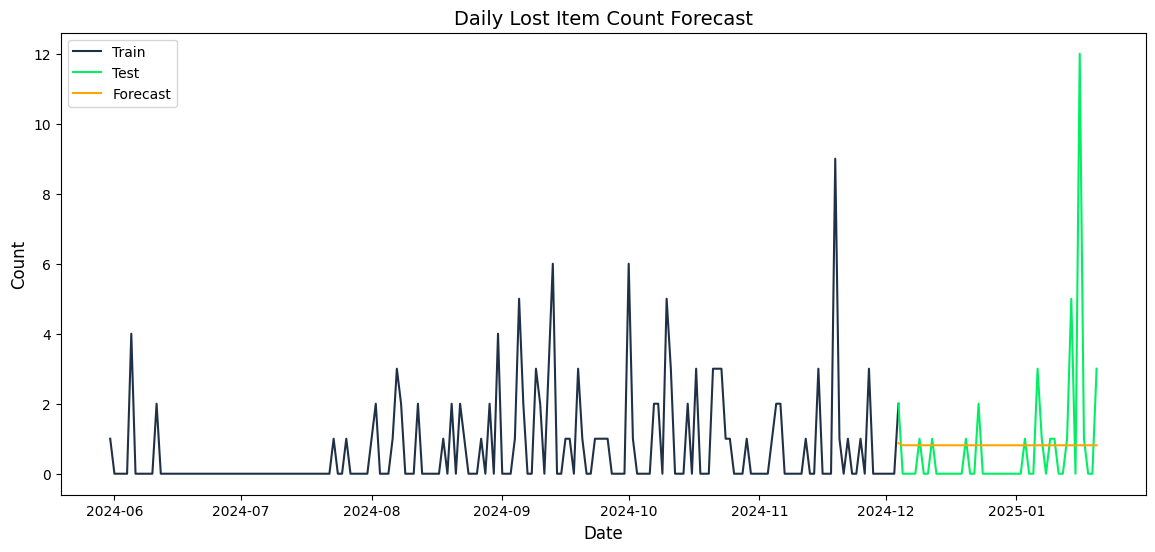

In [22]:
# Fit ARIMA on daily data
daily_forecast = fit_arima_and_forecast(
    train_test_split["daily"]["train"], 
    train_test_split["daily"]["test"], 
    order=(1, 1, 1), 
    title="Daily Lost Item Count Forecast"
)

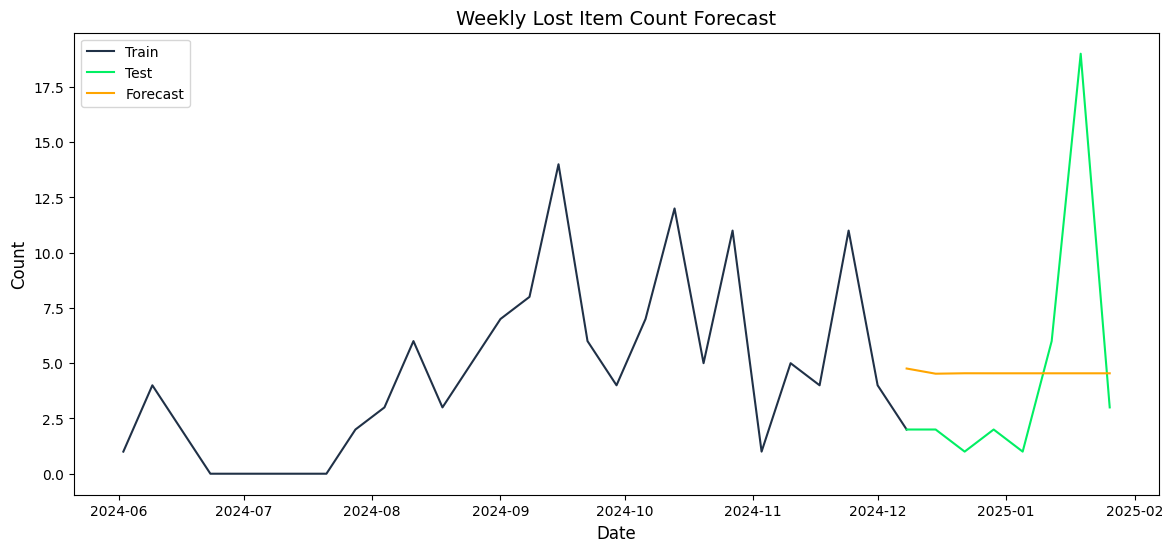

In [23]:
# Fit ARIMA on weekly data
weekly_forecast = fit_arima_and_forecast(
    train_test_split["weekly"]["train"], 
    train_test_split["weekly"]["test"], 
    order=(1, 1, 1), 
    title="Weekly Lost Item Count Forecast"
)

#### Model Diagnostics

We will focus mainly on the following metrics to evaluate our models:

|Statistics|Description|
|---|---|
|Akaike Information Criterion (AIC) | Measures the relative quality of the model. Lower AIC values indicate a better-fitting model.|
|Bayesian Information Criterion (BIC)| Similar to AIC but penalizes model complexity more strongly. Lower BIC values indicate a better-fitting model.|
|Residuals| The differences between observed data points and the model's predictions. Ideally, residuals should follow a random "white noise" pattern (residuals with no discernible patterns, correlations, or structure), indicating the model has captured all underlying structure in the data.|
|Autoregressive (AR) | Measures how much the most recent past value influences the current value|
|Moving Average (MA) | Captures the effect of past forecast errors on the current value.|

##### 1. Daily Forecast Diagnostics

The ARIMA model for daily forecasts yields the following results:

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  188
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -317.655
Date:                Mon, 20 Jan 2025   AIC                            641.310
Time:                        13:06:05   BIC                            651.004
Sample:                    05-31-2024   HQIC                           645.238
                         - 12-04-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0493      0.091      0.543      0.587      -0.129       0.227
ma.L1         -0.9569      0.023    -42.079      0.000      -1.001      -0.912
sigma2         1.7277      0.073     23.537      0.0

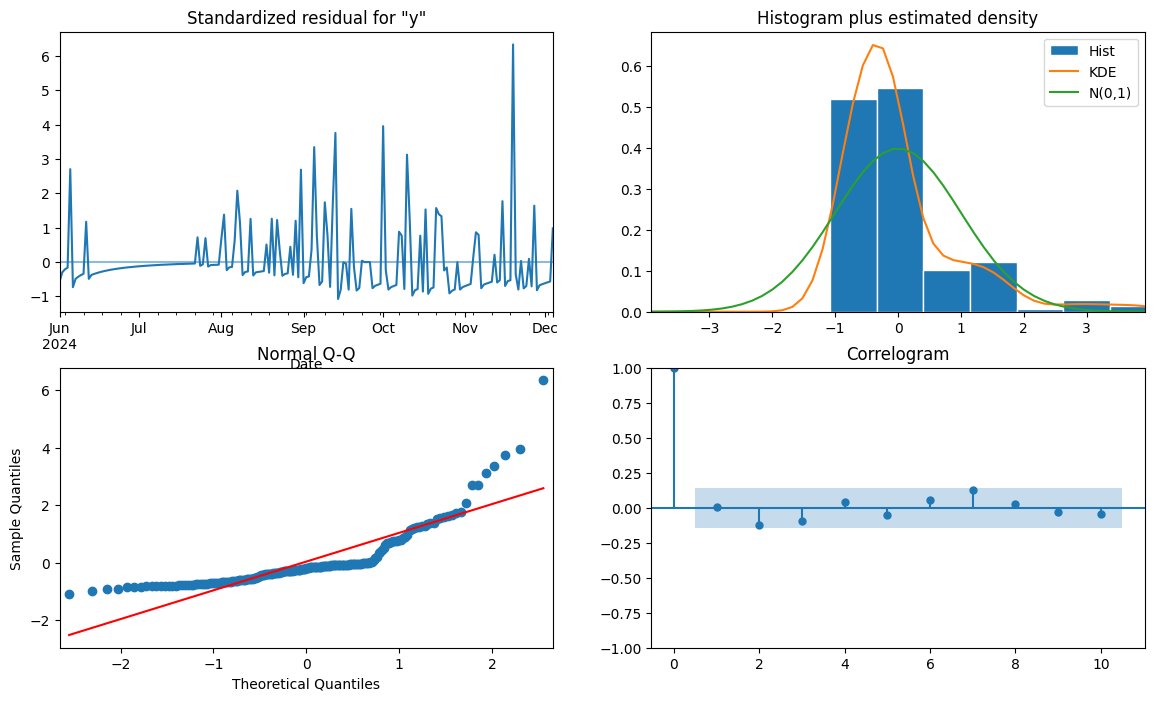

In [24]:
print(daily_forecast.summary())

daily_forecast.plot_diagnostics(figsize=(14, 8))
plt.show()

Key observations:

- The AIC (632.518) and BIC (642.163) are slightly high, which suggest there might be room to improve the model's fit by tuning hyperparameters.
- While the residuals appear to exhibit some characteristics of white noise, the slight skewness and heteroskedasticity (as indicated by the high Jarque-Bera and Heteroskedasticity test results) suggest the model may not fully capture the data dynamics.
- The AR has a p-value of 0.599 and is statistically insignificant (p > 0.05), which indicates that the AR component doesn't meaningfully contribute to the model's predictions
- The MA has a p-value of 0.000 and is statistically significant (p < 0.05), which implies that past errors contribute signficantly to current forecast.

##### 2. Weekly Forecast Diagnostics

The ARIMA model for weekly forecasts provides the following results:

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   28
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -72.345
Date:                Mon, 20 Jan 2025   AIC                            150.689
Time:                        13:06:06   BIC                            154.577
Sample:                    06-02-2024   HQIC                           151.845
                         - 12-08-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0849      0.312     -0.272      0.786      -0.697       0.527
ma.L1         -0.6068      0.224     -2.711      0.007      -1.046      -0.168
sigma2        12.1822      3.596      3.387      0.0

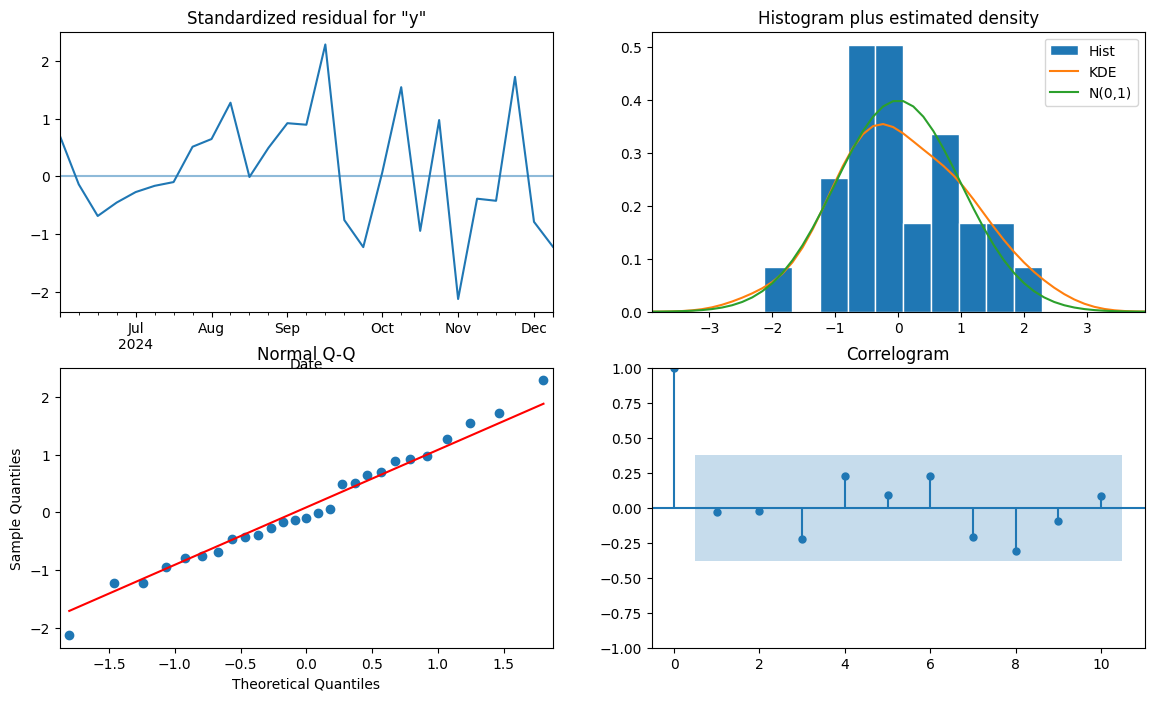

In [25]:
print(weekly_forecast.summary())

weekly_forecast.plot_diagnostics(figsize=(14, 8))
plt.show()

Key observations:

- The AIC (144.758) and BIC (148.532) are lower compared to the daily model, reflecting better relative fit. However, the small sample size (27 observations) may impact model stability and reliability.
- The residuals mostly exhibit characteristics of white noise, which suggests a reasonable fit. The skewness (0.10) and kurtosis (2.80) are also near normal levels, which aligns with assumptions of residual normality.
- The AR has a p-value of 0.553 and is statistically insignificant (p > 0.05), which indicates that the AR component doesn't meaningfully contribute to the model's predictions
- The MA has a p-value of 0.011 and is significant (p < 0.05), which implies that past errors contribute signficantly to current forecast.

#### Model Evaluation

We also use Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE) to measure forecast accuracy.

In [26]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

def evaluate_forecast(test, forecast, title=""):
    rmse = root_mean_squared_error(test, forecast)
    mape = (abs((test - forecast) / test).mean()) * 100

    print(f"{title} Evaluation:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAPE: {mape:.2f}%")

In [27]:
evaluate_forecast(
    train_test_split["daily"]["test"], 
    daily_forecast.forecast(steps=len(train_test_split["daily"]["test"])), 
    title="Daily Forecast"
)

Daily Forecast Evaluation:
  RMSE: 1.92
  MAPE: inf%


A RMSE of 1.9 indicates that, on average, the model's daily predictions deviate by approximately 1.9 units from actual count of lost items. MAPE is not interpretable due to division by zero in some test values.

In [28]:
evaluate_forecast(
    train_test_split["weekly"]["test"], 
    weekly_forecast.forecast(steps=len(train_test_split["weekly"]["test"])), 
    title="Weekly Forecast"
)

Weekly Forecast Evaluation:
  RMSE: 5.69
  MAPE: 160.53%


A RMSE of 5.88 shows greater deviation from actual weekly values. This reflects the model's difficulty in capturing broader weekly patterns compared to the daily predictions. A MAPE of 249.65% is also extremely high, which signifies poor reliability for percentage-based errors, likely influenced by the limited data.

#### Results and Limitations

##### Evaluation Results
- The daily ARIMA model achieves better accuracy metrics (RMSE), but its AIC/BIC values and residual diagnostics suggest further optimization is needed.
- The weekly ARIMA model shows better residual stability but higher error metrics, highlighting challenges in capturing broader patterns due to limited data.

Future improvements for the models may include:

- Daily Model Improvements:
   - Fine-tune hyperparameters to improve AIC/BIC values.
   - Address heteroskedasticity and residual skewness, potentially by transforming the data or adding seasonal components.
     
- Weekly Model Improvements:
   - Increase data size for more stable parameter estimation.
   - Explore alternative models such as exponential smoothing or other machine learning approaches to better capture long-term trends.

##### Linear Nature of ARIMA
The ARIMA model assumes that the underlying relationships in the data can be adequately described by linear dependencies. While this works well for datasets with linear trends and simple seasonality, it has limitations when applied to:

- Nonlinear Data Patterns: Complex interactions or nonlinear relationships cannot be effectively captured by ARIMA.
- Changing Dynamics: Sudden changes, long-term nonlinear trends, or interactions across multiple factors are beyond ARIMA's scope.

##### Observations in Forecast Plots
The forecast plot for the ARIMA model shows a nearly linear trend for predictions, which fails to capture the variability and curvature seen in the test data. The model oversimplifies the dynamics, leading to forecasts that lack nuance and fail to track actual patterns in the test data. Consequently, this mismatch suggests that the model may not be adequately representing the underlying structure of the dataset.

##### Recommendation
While ARIMA offers a solid baseline for time series forecasting, its linear assumptions limit its ability to fully capture the nuances of the dataset, as shown by the mismatch in forecast plots and evaluation metrics. To overcome these challenges and improve predictive performance, we propose transitioning to LSTM models, which are designed to capture complex, nonlinear relationships and long-term dependencies.


### LSTM Model